In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.
C:\Users\Fer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Fer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Fer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Fer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Fu

In [2]:
intubados = pd.read_csv("intubados.csv", parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','intubados'])
intubados

fecha
2020-03-24     39
2020-03-25     33
2020-03-26     42
2020-03-27     60
2020-03-28     78
             ... 
2021-01-07    352
2021-02-07    362
2021-03-07    380
2021-04-07    378
2021-05-07    395
Name: intubados, Length: 469, dtype: int64

In [3]:
#Contar los intubados por año
print(len(intubados['2020']))
print(len(intubados['2021']))

283
186


In [4]:
#Promedio mensual
meses =intubados.resample('M').mean()
meses

fecha
2020-01-31     981.888889
2020-02-29     972.444444
2020-03-31     545.705882
2020-04-30     798.074074
2020-05-31    1269.392857
2020-06-30    1180.185185
2020-07-31    1063.750000
2020-08-31     942.535714
2020-09-30     912.703704
2020-10-31     934.142857
2020-11-30    1066.629630
2020-12-31    1534.785714
2021-01-31    2052.807692
2021-02-28    1586.695652
2021-03-31    1272.500000
2021-04-30     941.960000
2021-05-31     609.269231
2021-06-30     547.958333
2021-07-31    1301.833333
2021-08-31    1280.833333
2021-09-30    1273.500000
2021-10-31    1268.333333
2021-11-30    1269.333333
2021-12-31    1252.666667
Freq: M, Name: intubados, dtype: float64

In [5]:
PASOS=7
 
# convertir serie temporal en datos de tipo supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    intubados = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(intubados.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast secuencia (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(intubados.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # quitar NaN 
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = intubados.values
# todos los datos son float
values = values.astype('float32')
# normalizar de -1 a 1
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.994956,-1.000000,-0.992434,-0.977301,-0.962169,-0.957125,-0.936108,-0.925179
8,-1.000000,-0.992434,-0.977301,-0.962169,-0.957125,-0.936108,-0.925179,-0.915931
9,-0.992434,-0.977301,-0.962169,-0.957125,-0.936108,-0.925179,-0.915931,-0.907524
10,-0.977301,-0.962169,-0.957125,-0.936108,-0.925179,-0.915931,-0.907524,-0.917612
11,-0.962169,-0.957125,-0.936108,-0.925179,-0.915931,-0.907524,-0.917612,-0.916772


In [6]:
# Dividir en train y test
values = reframed.values
n_train_days = 283+186 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# dividir en entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape entrada a 3 dimensiones [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(432, 1, 7) (432,) (30, 1, 7) (30,)


In [7]:
#Modelo. Secuencial, activación tangente hiperbólica, optimizador adam  
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


In [8]:
#entrenar el modelo
EPOCHS=50

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 7)              56        
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________

Train on 432 samples, validate on 30 samples
Epoch 1/50
432/432 [==============================] - 0s 505us/step - loss: 0.5075 - mse: 0.4460 - val_loss: 0.4674 - val_mse: 0.2196
Epoch 2/50
432/432 [==============================] - 0s 180us/step - loss: 0.1156 - mse: 0.0293 - val_loss: 0.1531 - val_mse: 0.0242
Epoch 3/50
432/432 [==============================] - 0s 165us/step - loss

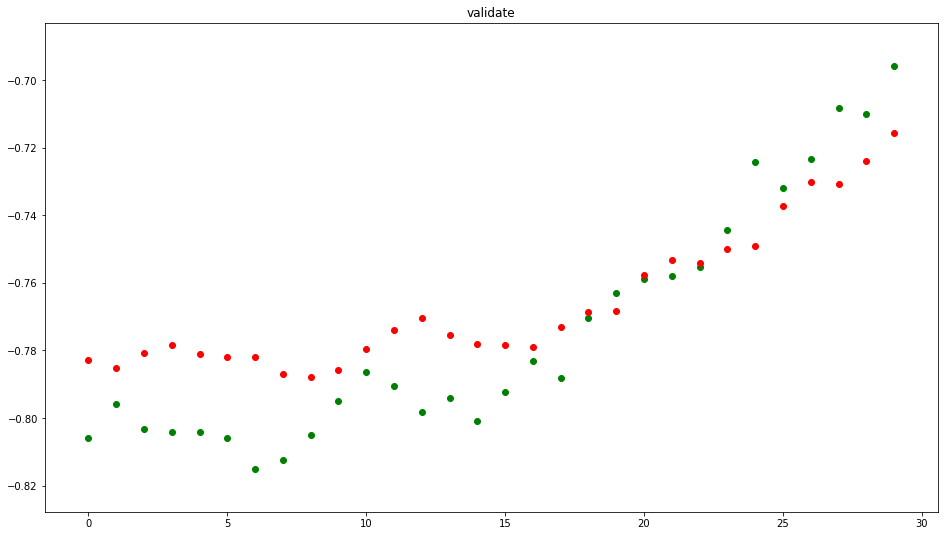

In [9]:
#Validación del modelo
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

In [11]:
#tomamos los últimos días
ultimosDias = intubados['2021-06-22':'2021-07-05']
ultimosDias

fecha
2021-07-01    2172
2021-07-02    2187
2021-07-03    1556
2021-07-04    1027
2021-07-05     593
2021-06-22     291
2021-06-23     285
2021-06-24     306
2021-06-25     315
2021-06-26     320
2021-06-27     321
2021-06-28     324
2021-06-29     337
2021-06-30     361
Name: intubados, dtype: int64

In [12]:
#Volver a procesar los datos
values = ultimosDias.values
values = values.astype('float32')
# Normalizar
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,0.984227,1.000000,0.336488,-0.219769,-0.676130,-0.993691,-1.000000
8,1.000000,0.336488,-0.219769,-0.676130,-0.993691,-1.000000,-0.977918
9,0.336488,-0.219769,-0.676130,-0.993691,-1.000000,-0.977918,-0.968454
10,-0.219769,-0.676130,-0.993691,-1.000000,-0.977918,-0.968454,-0.963197
11,-0.676130,-0.993691,-1.000000,-0.977918,-0.968454,-0.963197,-0.962145
12,-0.993691,-1.000000,-0.977918,-0.968454,-0.963197,-0.962145,-0.958991
13,-1.000000,-0.977918,-0.968454,-0.963197,-0.962145,-0.958991,-0.945321


In [13]:
#Convertir a array la última semana
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[-1.        , -0.97791797, -0.96845424, -0.96319664,
         -0.9621451 , -0.9589906 , -0.9453207 ]]], dtype=float32)

In [14]:
#Predicción
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-1.         -0.97791797 -0.96845424 -0.96319664 -0.9621451
   -0.9589906  -0.9453207 ]]]
[[[-0.97791797 -0.96845424 -0.96319664 -0.9621451  -0.9589906
   -0.9453207  -0.8560839 ]]]
[[[-0.96845424 -0.96319664 -0.9621451  -0.9589906  -0.9453207
   -0.8560839  -0.8361746 ]]]
[[[-0.96319664 -0.9621451  -0.9589906  -0.9453207  -0.8560839
   -0.8361746  -0.8037949 ]]]
[[[-0.9621451 -0.9589906 -0.9453207 -0.8560839 -0.8361746 -0.8037949
   -0.785542 ]]]
[[[-0.9589906  -0.9453207  -0.8560839  -0.8361746  -0.8037949
   -0.785542   -0.77458435]]]
[[[-0.9453207  -0.8560839  -0.8361746  -0.8037949  -0.785542
   -0.77458435 -0.7577111 ]]]


In [15]:
#Imprimir predicción de la siguiente semana
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[421.86418863],
       [440.79795512],
       [471.59103896],
       [488.94955654],
       [499.37029013],
       [515.41674269],
       [510.35826072]])